1.8V-Tot-resized2.dat: mu = 2.006542e+01 ± 5.943852e-02, t0 = 3.614038e+03 ± 5.877045e+00
10.0V-Tot-resized2.dat: mu = 1.602558e+01 ± 3.477920e-02, t0 = 5.508414e+02 ± 9.802042e-01
10.2V-Tot-resized2.dat: mu = 1.265461e+01 ± 2.623352e-02, t0 = 7.062374e+02 ± 1.159042e+00
10.5V-Tot-resized2.dat: mu = 1.194821e+01 ± 2.771407e-02, t0 = 6.400767e+02 ± 1.357044e+00
11.0V-Tot-resized2.dat: mu = 1.178173e+01 ± 2.747937e-02, t0 = 6.280037e+02 ± 1.313323e+00
11.5V-Tot-resized2.dat: mu = 1.291681e+01 ± 1.989742e-02, t0 = 6.338108e+02 ± 7.453027e-01
12.5V-Tot-resized2.dat: mu = 1.225418e+01 ± 2.707783e-02, t0 = 5.302863e+02 ± 1.045250e+00
15.0V-Tot-resized2.dat: mu = 1.226026e+01 ± 2.269048e-02, t0 = 4.444017e+02 ± 7.319221e-01
17.5V-Tot-resized2.dat: mu = 1.232825e+01 ± 1.562046e-02, t0 = 3.764984e+02 ± 4.202623e-01
2.0V-Tot-resized2.dat: mu = 1.754382e+01 ± 5.380822e-02, t0 = 3.260266e+03 ± 6.241453e+00
2.3V-Tot-resized2.dat: mu = 1.919429e+01 ± 5.481642e-02, t0 = 3.103238e+03 ± 4.658286e+00
2.

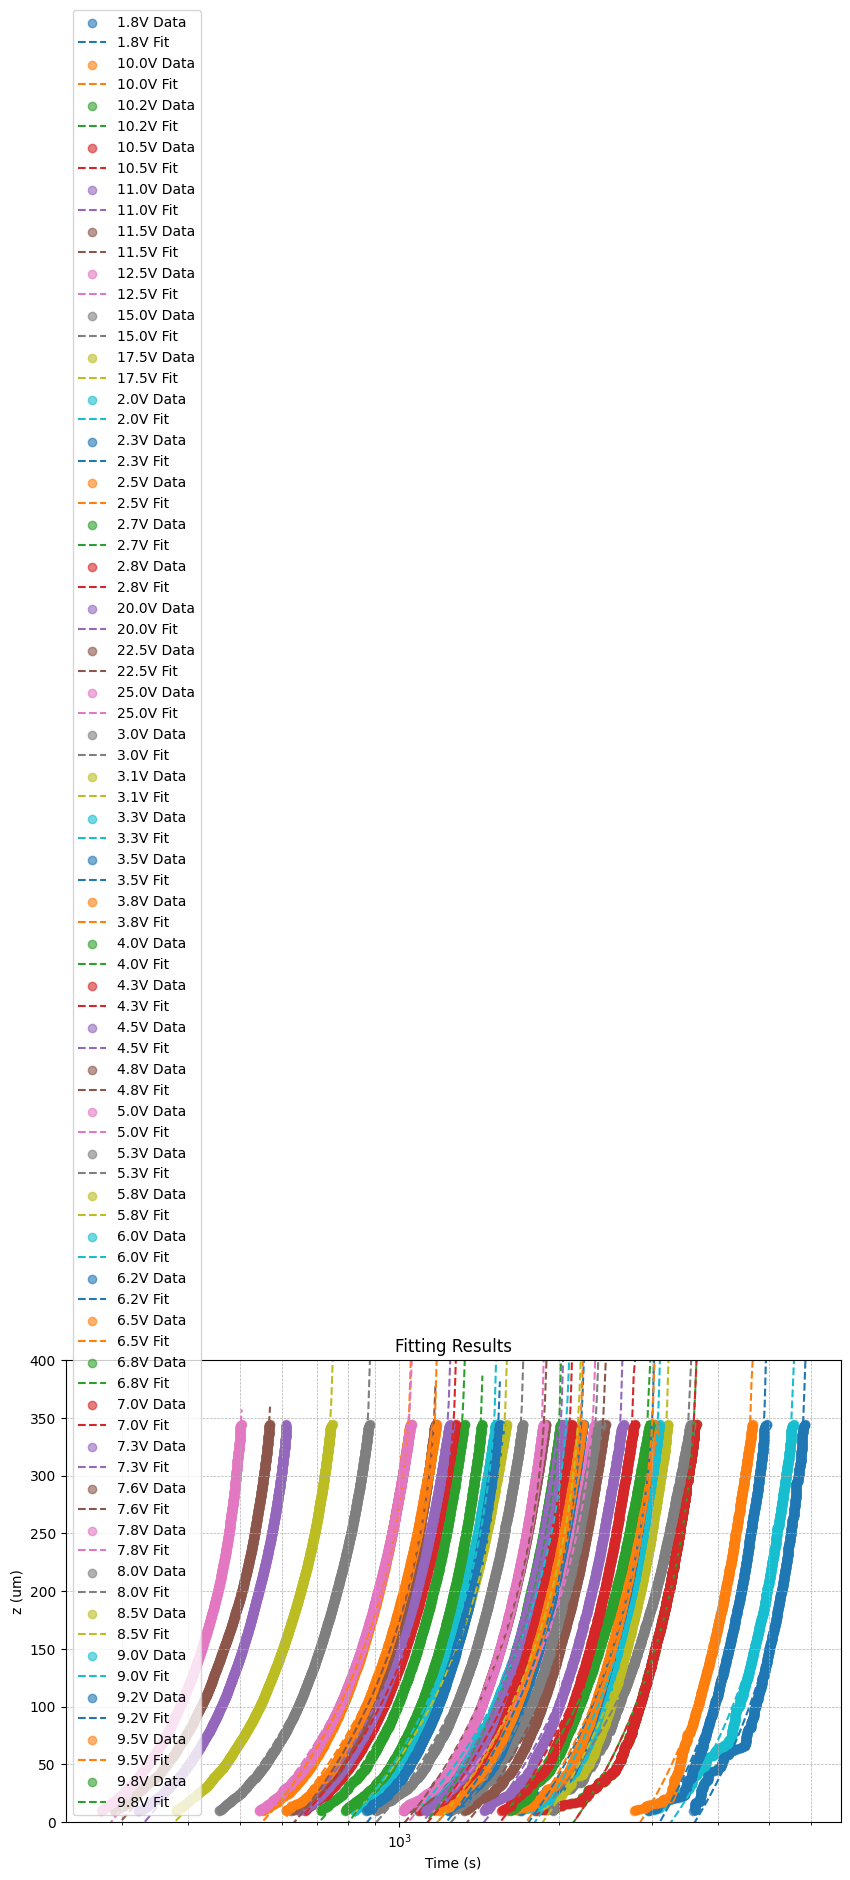

In [11]:
import os
import re
import numpy as np
import pandas as pd
import scipy.optimize as opt
import matplotlib.pyplot as plt

# 상수 설정
L = 400  # um

def model(t, mu, t0, V):
    """ sqrt 내부 값이 음수가 되지 않도록 max(0, ...) 적용 """
    return L - np.sqrt(np.maximum(0, L**2 - 2 * V * mu * (t - t0)))

def extract_voltage(filename):
    """ 파일명에서 전압 추출 """
    match = re.search(r'([\d\.]+)V', filename)
    return float(match.group(1)) if match else None

def fit_data(file_path, V):
    """ 데이터 로드 및 피팅 수행 """
    data = np.loadtxt(file_path, delimiter=",")
    t, z = data[:, 1], data[:, 0]
    
    # 유효한 데이터 필터링 (t > 0, 0 <= z <= L)
    mask = (t > 0) & (z >= 0) & (z <= L)
    t, z = t[mask], 400.0 - z[mask]
    
    # 초기 추정값 설정
    mu_init, t0_init = 1e-9, np.percentile(t, 5)
    bounds = ([1e-12, 0], [np.inf, np.inf])  # mu는 0보다 작아지지 않도록 설정
    
    try:
        popt, pcov = opt.curve_fit(lambda t, mu, t0: model(t, mu, t0, V), t, z, p0=[mu_init, t0_init], bounds=bounds)
        mu, t0 = popt
        sigma_mu, sigma_t0 = np.sqrt(np.diag(pcov))  # 표준 편차(오차) 계산
        return t, z, mu, t0, sigma_mu, sigma_t0
    except (RuntimeError, ValueError):
        print(f"Fit failed for V={V}V")
        return t, z, np.nan, np.nan, np.nan, np.nan

# 폴더 내 파일 처리
folder_path = "."  # 데이터 폴더 경로
results = []
plt.figure(figsize=(10, 6))

for filename in os.listdir(folder_path):
    if filename.endswith(".dat"):
        file_path = os.path.join(folder_path, filename)
        V = extract_voltage(filename)
        if V is not None:
            t, z, mu, t0, sigma_mu, sigma_t0 = fit_data(file_path, V)
            results.append([filename, V, mu, sigma_mu, t0, sigma_t0])
            print(f"{filename}: mu = {mu:.6e} ± {sigma_mu:.6e}, t0 = {t0:.6e} ± {sigma_t0:.6e}")
            
            # 플로팅
            if not np.isnan(mu):
                t_fit = np.logspace(np.log10(min(t)), np.log10(max(t)), 100)
                z_fit = model(t_fit, mu, t0, V)
                plt.scatter(t, z, label=f"{V}V Data", alpha=0.6)
                plt.plot(t_fit, z_fit, label=f"{V}V Fit", linestyle="--")

# 플롯 설정
plt.xscale("log")
plt.xlabel("Time (s)")
plt.ylabel("z (um)")
plt.ylim(0, L)  # z 범위 제한
plt.legend()
plt.title("Fitting Results")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()

# 결과 저장
results_df = pd.DataFrame(results, columns=["Filename", "V", "mu", "mu_err", "t0", "t0_err"])
results_df.to_csv("fitting_results_with_errors.csv", index=False)


In [27]:
import os
import numpy as np
import pandas as pd
import scipy.optimize as opt

# ✅ 모델 함수 정의
def model(t, mu, t0, V):
    """ sqrt 내부 값이 음수가 되지 않도록 max(0, ...) 적용 """
    return L - np.sqrt(np.maximum(0, L**2 - 2 * V * mu * (t - t0)))

# ✅ 데이터 피팅 함수
def fit_data(file_path, V):
    # 파일에서 데이터 로드
    data = np.loadtxt(file_path, delimiter=",")
    t, z = data[:, 1], 400.0 - data[:, 0]

    # 초기값 및 피팅 수행
    mu_init, t0_init = 1e-6, np.min(t)
    bounds = ([0, 0], [np.inf, np.inf])
    
    try:
        popt, pcov = opt.curve_fit(lambda t, mu, t0: model(t, mu, t0, V), 
                                   t, z, p0=[mu_init, t0_init], bounds=bounds)
        mu, t0 = popt
        perr = np.sqrt(np.diag(pcov))  # 표준 오차 (mu_err, t0_err)
    except:
        print(f"⚠ 피팅 실패: {file_path}")
        mu, t0, perr = np.nan, np.nan, (np.nan, np.nan)

    return t, z, (mu, t0), perr

# ✅ 전압 정보 추출 함수 (파일명에서 전압값 읽어오기)
def extract_voltage(filename):
    """ 파일명에서 전압 추출 """
    match = re.search(r'([\d\.]+)V', filename)
    return float(match.group(1)) if match else None

# ✅ 폴더 설정 및 데이터 처리
data_folder = "."  # 원본 데이터 폴더
output_folder = "./fittings"  # 결과 저장 폴더
os.makedirs(output_folder, exist_ok=True)

results = []  # 피팅 결과 저장 리스트

for filename in os.listdir(data_folder):
    if filename.endswith(".dat"):
        file_path = os.path.join(data_folder, filename)
        V = extract_voltage(filename)
        
        if V is not None:
            t, z, (mu, t0), (mu_err, t0_err) = fit_data(file_path, V)
            results.append([filename, V, mu, mu_err, t0, t0_err])

            # 🔥 개별 전압별 CSV 저장 (z, t, t_err 포함)
            t_err = np.full_like(t, mu_err)  # t_err는 mu_err 기반으로 설정
            df = pd.DataFrame({"z": z, "t": t, "t_err": t_err})
            df.to_csv(os.path.join(output_folder, f"Voltage_{V:.1f}V_fitting.csv"), index=False)
            print(f"✅ 저장 완료: {output_folder}")

# ✅ 전체 피팅 결과 CSV 저장
df_results = pd.DataFrame(results, columns=["Filename", "Voltage", "mu", "mu_err", "t0", "t0_err"])
df_results.to_csv(os.path.join(output_folder, "fitting_summary.csv"), index=False)

print(f"✅ 모든 결과가 {output_folder}/ 폴더에 저장됨!")


✅ 저장 완료: ./fittings
✅ 저장 완료: ./fittings
✅ 저장 완료: ./fittings
✅ 저장 완료: ./fittings
✅ 저장 완료: ./fittings
✅ 저장 완료: ./fittings
✅ 저장 완료: ./fittings
✅ 저장 완료: ./fittings
✅ 저장 완료: ./fittings
✅ 저장 완료: ./fittings
✅ 저장 완료: ./fittings
✅ 저장 완료: ./fittings
✅ 저장 완료: ./fittings
✅ 저장 완료: ./fittings
✅ 저장 완료: ./fittings
✅ 저장 완료: ./fittings
✅ 저장 완료: ./fittings
✅ 저장 완료: ./fittings
✅ 저장 완료: ./fittings
✅ 저장 완료: ./fittings
✅ 저장 완료: ./fittings
✅ 저장 완료: ./fittings
✅ 저장 완료: ./fittings
✅ 저장 완료: ./fittings
✅ 저장 완료: ./fittings
✅ 저장 완료: ./fittings
✅ 저장 완료: ./fittings
✅ 저장 완료: ./fittings
✅ 저장 완료: ./fittings
✅ 저장 완료: ./fittings
✅ 저장 완료: ./fittings
✅ 저장 완료: ./fittings
✅ 저장 완료: ./fittings
✅ 저장 완료: ./fittings
✅ 저장 완료: ./fittings
✅ 저장 완료: ./fittings
✅ 저장 완료: ./fittings
✅ 저장 완료: ./fittings
✅ 저장 완료: ./fittings
✅ 저장 완료: ./fittings
✅ 저장 완료: ./fittings
✅ 저장 완료: ./fittings
✅ 저장 완료: ./fittings
✅ 저장 완료: ./fittings
✅ 모든 결과가 ./fittings/ 폴더에 저장됨!
